In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%load_ext autoreload
%autoreload 2

from freedom.utils.pandel import pandel_gen

from scipy.spatial import distance

from scipy import optimize

In [2]:
%matplotlib inline
params = {'legend.fontsize': 17,
          'figure.figsize': (15, 9.3),
          'axes.labelsize': 24,
          'axes.titlesize': 24,
          'xtick.labelsize': 22,
          'ytick.labelsize': 22}
plt.rcParams.update(params)

# Constants

In [3]:
lambda_a = 100
lambda_s = 30
tau = 5000
n_ref = 1.3 # refractive index
c = 0.3 # m/ns
trck_e_to_l = 4.5 # m / GeV

ns_per_trck_m = 2451.4544553
ns_per_cscd_gev = 12818.970

r_detector = 0.1
q_eff = 0.3

# Time and Distance

In [4]:
# time distributon
pandel = pandel_gen(a=0.0, tau=tau, lambda_a=lambda_a, lambda_s=lambda_s, v=c/n_ref, name='pandel')

# survival probability
def survival(d):
    return np.exp(-d/lambda_a) / (d + r_detector)**2 * (r_detector)**2 / 4 * q_eff

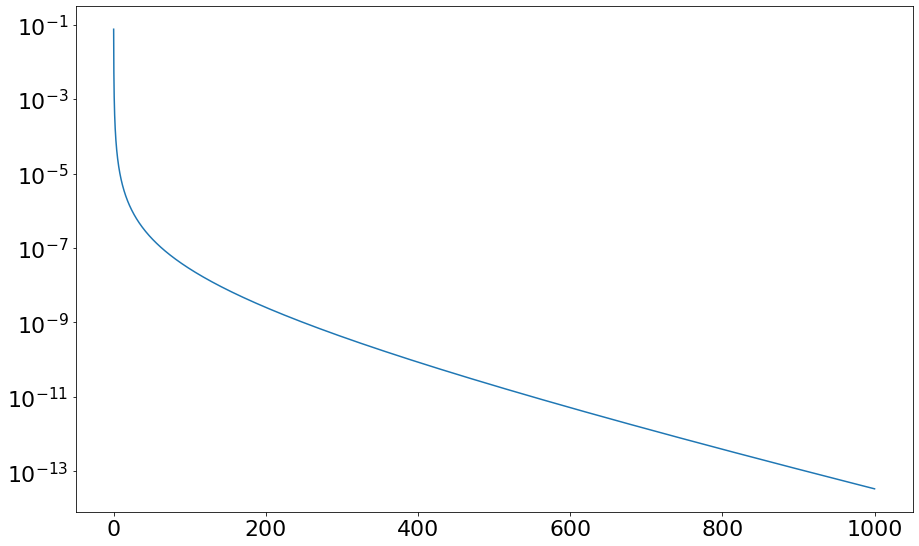

In [5]:
d = np.logspace(-5,3,1000)
plt.plot(d, survival(d))
plt.gca().set_yscale('log')

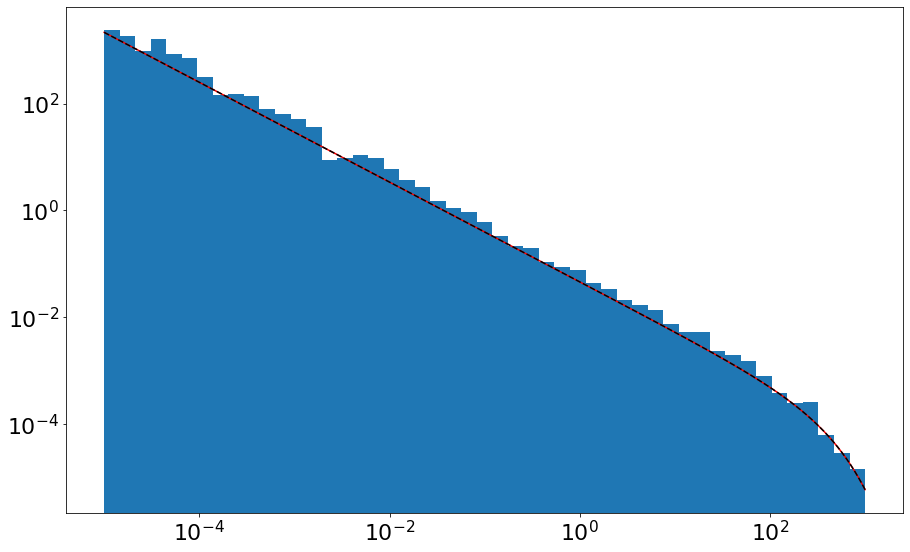

In [6]:
d=2

plt.hist(pandel(d=d).rvs(size=1000), density=True, bins=np.logspace(-5,3,50));
t = np.logspace(-5, 3, 1000)
plt.plot(t, pandel.pdf(t, d), c='r')
plt.plot(t, np.exp(pandel.logpdf(t, d)), c='k', ls='--')
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')

# Model of a segmented track + cascade

In [7]:
def model(x, y, z, t, az, zen, e_cscd, e_trck, step=1, inverted=True):
    """Simple event model
    
    Paramaters:
    -----------
    x, y, z, t, az, zen, e_cscd, e_trck : truth parameters
    step : step size for sampled track (m)
    inverted : interprete angles as neutrinos (incoming direction)
    
    Returns:
    --------
    collection of emmitters shape (n, 5), each segment with (x, y, z, t, n)
    """    
    length = e_trck * trck_e_to_l
    segments = np.arange(0, 1 +np.ceil(length/step))
    
    if inverted:
        zen = np.pi - zen
        az = az + np.pi
        
    dx = np.sin(zen) * np.cos(az)
    dy = np.sin(zen) * np.sin(az)
    dz = np.cos(zen)
    
    X = np.empty((len(segments), 5))
    
    X[:,0] = x + segments * dx * step
    X[:,1] = y + segments * dy * step
    X[:,2] = z + segments * dz * step
    X[:,3] = t + segments / c * step
    X[:,4] = ns_per_trck_m * length / len(segments)
    X[0,4] += ns_per_cscd_gev * e_cscd
    
    return X

# Building a detector

In [8]:
xx, yy, zz = np.meshgrid(np.linspace(-50, 50, 5), np.linspace(-50, 50, 5), np.linspace(-200, 100, 50))

detector = np.zeros((xx.size, 3))
detector[:,0] = xx.flatten()
detector[:,1] = yy.flatten()
detector[:,2] = zz.flatten()

In [9]:
#detector = np.vstack([[3.1,7.2,4.2,10.7,11.3,5.7,-1.0,-1.1], [-7.3,-6.7,3.5,2.7,-6.0,-10.5,-8.0,0.7], np.ones(8)]).T
#detector = np.repeat(detector, 25, axis=0)
#detector[:, 2] = np.tile(np.linspace(-17, 17, 25), 8)

In [10]:
detector.size

3750

# Event generator

In [11]:
def generate(truth, detector):
    
    # generate events
    
    segments = model(*truth, step=1)
    
    # x, y, z, d, t, n
    sensors = np.zeros((detector.shape[0], 6))
    sensors[:, :3] = detector

    sensors_x_segments = np.repeat(sensors[:,np.newaxis,:], segments.shape[0], axis=1)
    sensors_x_segments[:,:, 4] = distance.cdist(detector, segments[:,:3])

    n_exp = survival(sensors_x_segments[:,:, 4]) * segments[np.newaxis,:,4]
    n_obs = stats.poisson.rvs(mu=n_exp)
    sensors[:, 5] = np.sum(n_obs, axis=1)

    sensors_x_segments[:, :, 3] = segments[np.newaxis,:,3] + sensors_x_segments[:,:, 4]*n_ref/c
    sensors_x_segments = sensors_x_segments.reshape(-1, 6)

    # unused charge
    sensors_x_segments[:, 5] = 1
    hits = np.repeat(sensors_x_segments, n_obs.flatten(), axis=0)
    hits[:, 3] += pandel.rvs(d=hits[:,4])
    
    return hits, sensors[:, 5]

# Likelihood function

In [12]:
def nllh(params, hits, detector):
    segments = model(*params, step=1)

    # total charge part:
    sensors = np.zeros((detector.shape[0], 6))
    sensors[:, :3] = detector
    sensors_x_segments = np.repeat(sensors[:,np.newaxis,:], segments.shape[0], axis=1)
    sensors_x_segments[:,:, 4] = distance.cdist(detector, segments[:,:3])
    n_exp_tot = np.sum(survival(sensors_x_segments[:,:, 4]) * segments[:,4])
    
    # hit part:
    hits_x_segments = np.repeat(hits[:,np.newaxis,:], segments.shape[0], axis=1)
    hits_x_segments[:,:, 4] = distance.cdist(hits[:,:3], segments[:,:3])
    n_exp = survival(hits_x_segments[:,:, 4]) * segments[np.newaxis,:,4]
    # hit time - true time - direct line-of-sight time
    d_t = hits_x_segments[:,:,3] - segments[np.newaxis,:,3] - hits_x_segments[:,:, 4]*n_ref/c
    # Mixture of pdfs of all segments for hit in sensor, weighted by n_exp
    ps = np.clip(np.nan_to_num(pandel.pdf(x = d_t, d = hits_x_segments[:,:,4]) ), a_min=0, a_max=None) * n_exp
    # summing up mixture + pedestal (e.g. noise rate) to avoid log(0)
    ps = np.sum(ps, axis=1) + 1e-10
    
    # putting both together into extended llh
    nllh = -np.sum(np.log(ps)) + n_exp_tot
    return nllh

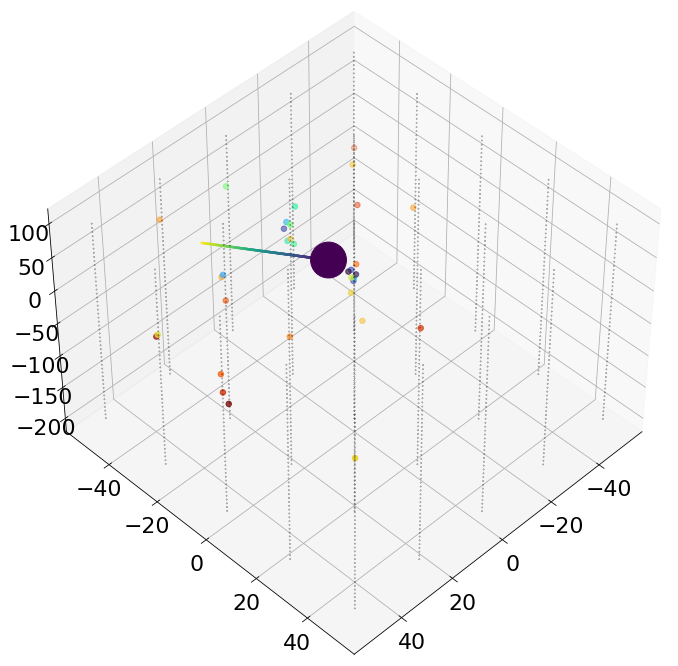

In [13]:
truth = [0., -10., 20, 0, 2, 1, 10, 10]

hits, n_obs = generate(truth, detector)

# plt.scatter(hits[:, 0] + np.random.randn(len(hits)), hits[:, 1]+ np.random.randn(len(hits)), s=3, c=np.log(hits[:,3]), cmap='turbo')
segments = model(*truth, step=0.1)
# plt.scatter(segments[:,0],segments[:,1],s=segments[:,4]/100, c=segments[:,3])
# plt.gca().set_xlim(-70,70)
# plt.gca().set_ylim(-70,70)

fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(projection='3d')
ax.scatter(detector[:,0],detector[:,1],detector[:,2],s=1, c='k', marker='x', alpha=0.3)
ax.scatter(segments[:,0],segments[:,1],segments[:,2],s=segments[:,4]/100, c=segments[:,3])
ax.scatter(hits[:, 0] + np.random.randn(len(hits)), hits[:, 1]+ np.random.randn(len(hits)), hits[:, 2]+ np.random.randn(len(hits)), s=30, c=np.log(hits[:,3]), cmap='turbo')
ax.view_init(45, 45)

In [14]:
import dama as dm

In [15]:
%%time
d = dm.GridData(x = np.linspace(-100, 100, 200), y=np.linspace(-100, 100, 200))
llhs = []
p = np.copy(truth)

for x, y in zip(d.x.flat(), d.y.flat()):
    p[0] = x
    p[1] = y
    llhs.append(nllh(p, hits, detector))

d.llh = np.array(llhs).reshape(d.shape)

CPU times: user 1min 6s, sys: 0 ns, total: 1min 6s
Wall time: 1min 6s


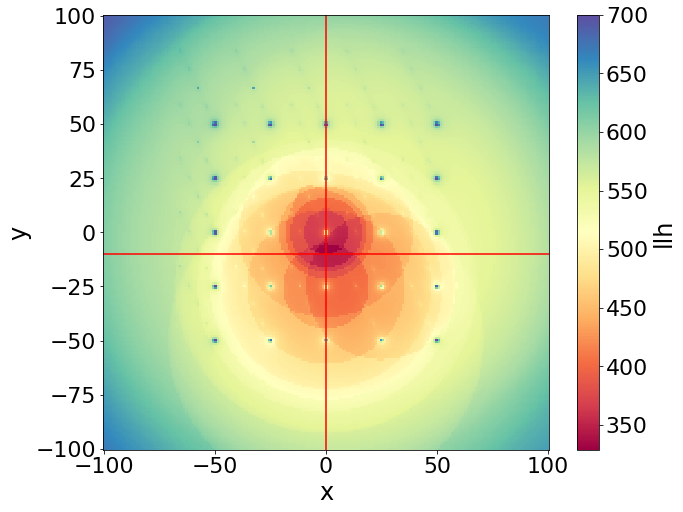

In [16]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

d.plot(cmap="Spectral", cbar=True, vmax=700)
plt.gca().axvline(truth[0], c='r')
plt.gca().axhline(truth[1], c='r')

In [17]:
%%time
d1 = dm.GridData(y=np.linspace(-100, 100, 1000))
llhs = []
p = np.copy(truth)
for y in d1.y:
    p[1] = y
    llhs.append(nllh(p, hits, detector))
d1.llh = np.array(llhs)

CPU times: user 1.72 s, sys: 0 ns, total: 1.72 s
Wall time: 1.71 s


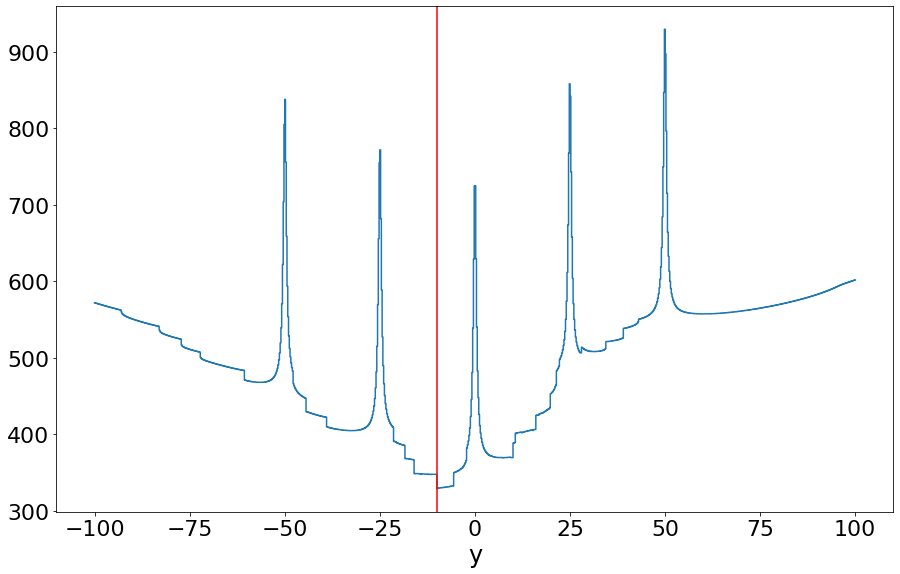

In [18]:
d1.plot()
plt.axvline(truth[1], c='r')

# Reco test

In [19]:
from spherical_opt import spherical_opt

In [20]:
x0 = np.random.rand(30, 8)

x0[:, :4] *= 100
x0[:, :2] -= 50
x0[:, 4] *= 2*np.pi
x0[:, 5] *= np.pi
x0[:, 6:] *= 2

In [21]:
res = spherical_opt.spherical_opt(lambda x : nllh(np.concatenate([x[:6], np.exp(x[6:])]), hits, detector), method='CRS2', spherical_indices=[(4,5),], initial_points=x0, )

In [22]:
reco = np.concatenate([res['x'][:6], np.exp(res['x'][6:])])

In [23]:
nllh(reco, hits, detector)

316.9567713081095

In [24]:
nllh(truth, hits, detector)

327.4609554850025

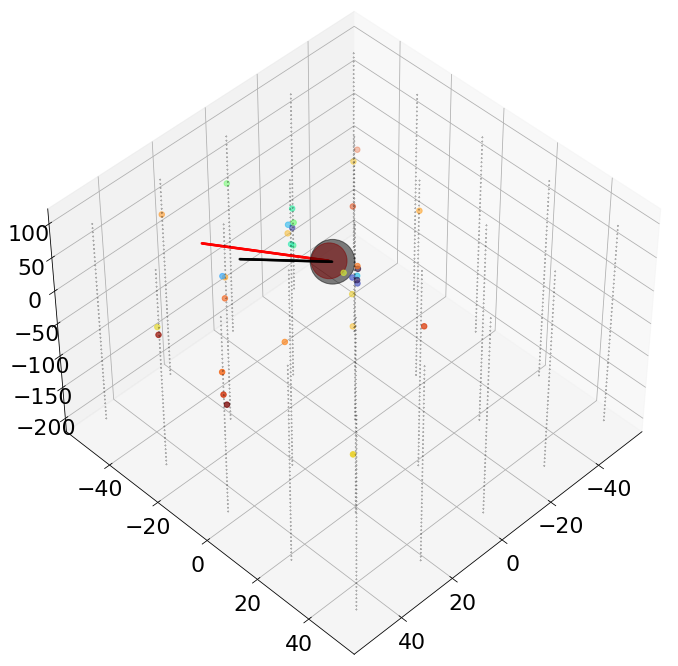

In [25]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(projection='3d')
ax.scatter(detector[:,0],detector[:,1],detector[:,2],s=1, c='k', marker='x', alpha=0.3)
segments = model(*truth, step=0.1)
ax.scatter(segments[:,0],segments[:,1],segments[:,2],s=segments[:,4]/100, c='r', alpha=0.5)
segments = model(*reco, step=0.1)
ax.scatter(segments[:,0],segments[:,1],segments[:,2],s=segments[:,4]/100, c='k', alpha=0.5)
ax.scatter(hits[:, 0] + np.random.randn(len(hits)), hits[:, 1]+ np.random.randn(len(hits)), hits[:, 2]+ np.random.randn(len(hits)), s=30, c=np.log(hits[:,3]), cmap='turbo')
ax.view_init(45, 45)